In [261]:
import calitp
from calitp.tables import tbl
from siuba import *

import pandas as pd
import numpy as np

import geopandas as gpd
import seaborn as sns

## About how many validators are needed to connect to LOSSAN?

### Set up views

In [3]:
transit_stacks = tbl.views.transitstacks()

In [4]:
lossan_counties = ['San Luis Obispo', 'Santa Barbara', 'Ventura',
                  'Los Angeles', 'San Diego']

In [5]:
dim_stops = (tbl.views.gtfs_schedule_dim_stops()
                 >> select(_.itp_id == _.calitp_itp_id, _.stop_key, _.stop_id, _.stop_lat, _.stop_lon, _.stop_name)
                )

In [181]:
dim_routes = (tbl.views.gtfs_schedule_dim_routes()
                 >> select(_.itp_id == _.calitp_itp_id, _.route_key, _.route_type)
                )

In [202]:
weekday_rail_stops = (tbl.views.gtfs_schedule_fact_daily_feed_routes()
                    >> filter(_.date == '2021-09-01') #weekday service
                    >> select(_.route_key, _.date)
                    >> inner_join(_, dim_routes, on='route_key')
                    >> filter(_.route_type != '3')
                    >> inner_join(_, tbl.views.gtfs_schedule_index_feed_trip_stops(), on='route_key')
                    >> collect()
                    >> distinct(_.stop_key, _keep_all = True)
                    >> group_by(_.itp_id)
                    >> count(_.route_type)
                      )

In [6]:
weekday_stops = (tbl.views.gtfs_schedule_fact_daily_feed_stops()
                    >> filter(_.date == '2021-09-01') #weekday service
                    >> select(_.stop_key, _.date)
                    >> inner_join(_, dim_stops, on='stop_key')
                      )

In [7]:
info_cols = ['itp_id', 'transit_provider', 'ntd_id',
             'modes', 'county', 'legacy_ntd_id']

vehicle_cols = ['bus', 'articulated_bus', 'over_the_road_bus',
                'school_bus', 'trolleybus', 'vintage_historic_trolley',
                'streetcar']

paratransit_cols = ['van', 'cutaway', 'automobile',
                     'minivan', 'sport_utility_vehicle']

In [8]:
lossan_county_stops = (transit_stacks
                         >> filter(_.county.isin(lossan_counties))
                         >> select(_.itp_id)
                         >> inner_join(_, weekday_stops, on = "itp_id")
                         >> collect()
                    )

In [9]:
lossan_operators = (transit_stacks
                         >> filter(_.county.isin(lossan_counties))
                         >> select(*(info_cols + vehicle_cols + paratransit_cols))
                         >> collect()
                    )

In [219]:
lossan_operators.replace(' ', np.nan, inplace=True)
for col in (vehicle_cols + paratransit_cols):
    lossan_operators = lossan_operators.astype({col:'float64'})

In [221]:
lossan_connecting_rail_stops = (transit_stacks
                         >> filter(_.county.isin(lossan_counties))
                         >> select(*info_cols)
                         >> collect()
                         >> inner_join(_, weekday_rail_stops, on='itp_id')
                         >> rename(rail_stop_count = _.n)
                               )

### Estimate validators required per vehicle/stop

In [218]:
## Eric's estimation...
validators_needed = pd.Series({'bus': 2, 'articulated_bus': 3, 'over_the_road_bus': 1,
                             'vintage_historic_trolley': 2, 'trolleybus': 2, 'streetcar': 2,
                             'van': 1, 'cutaway': 1, 'automobile': 1,
                             'minivan': 1, 'sport_utility_vehicle': 1, 'school_bus': 1,
                             'lrt_stn':6, 'hrt_stn':15, 'la_union_stn':40,
                             'commuter_rail_stn':6, 'interchange':20, ## interchange is for places like 7th/Metro
                             'ferry_stn':4})
rail_validators_needed = pd.Series({'0': 6, '1': 10, '2': 6, '4': 4})

## Rail/Ferry

### Finding LOSSAN stations

In [13]:
## We don't quite have this (Amtrak) in data warehouse yet...
## from https://gis.data.ca.gov/datasets/63697b01616b4df68e2b316e73d7a4d6_0/
ca_rail = gpd.read_file('./California_Rail_Stations.geojson')

In [14]:
lossan_lines = ['Ventura County Line',
                'Burbank-Bob Hope Airport,Ventura County Line',
                '91 Line,Antelope Valley Line,Burbank-Bob Hope Airport,Orange County Line,Riverside Line,San Bernardino Line,Ventura County Line',
                'Antelope Valley Line,Burbank-Bob Hope Airport,Ventura County Line',
                'Orange County Line',
                '91 Line,Orange County Line',
                'Inland Empire-Orange County Line,Orange County Line',
                'Coaster,Inland Empire-Orange County Line,Orange County Line',
                'Coaster',
                ]

In [15]:
lossan_stations = ca_rail[ca_rail['PASS_NETWO'].str.contains('Surfliner')
                       | ca_rail['COMM_NETWO'].isin(lossan_lines)]

### Connecting rail/ferry transit

In [236]:
lossan_connecting_rail_stops['validator_count'] = lossan_connecting_rail_stops.apply(
                                lambda x: x.rail_stop_count * rail_validators_needed[x.route_type], axis=1)
lossan_connecting_rail_stops['is_paratransit'] = False
lossan_connecting_rail_stops['lossan_connection'] = True

## Direct LOSSAN Connections

### Find bus stops near LOSSAN stations

In [239]:
lossan_county_stops = gpd.GeoDataFrame(
                lossan_county_stops,
                geometry = gpd.points_from_xy(lossan_county_stops.stop_lon, lossan_county_stops.stop_lat),
                crs='EPSG:4326')

In [240]:
## project stations for buffer
lossan_stations = lossan_stations.to_crs('EPSG:6414') ## https://epsg.io/6414 (meters)
lossan_stations.geometry = lossan_stations.geometry.buffer(800) ## 800 meter buffer ~ .5mi

In [241]:
lossan_connect_stops = gpd.clip(lossan_county_stops.to_crs('EPSG:6414'), lossan_stations)

In [242]:
# lossan_stations.plot()

In [243]:
# lossan_county_stops.plot()

In [244]:
# lossan_connect_stops.plot()

In [245]:
lossan_connect_operators = (transit_stacks 
     >> filter(_.itp_id.isin(lossan_connect_stops.itp_id))
     >> select(*(info_cols + vehicle_cols + paratransit_cols))
     >> mutate(lossan_connection = True)
     >> collect()
    )

In [246]:
lossan_connect_operators.replace(' ', np.nan, inplace=True)
for col in (vehicle_cols + paratransit_cols):
    lossan_connect_operators = lossan_connect_operators.astype({col:'float64'})

In [247]:
non_connect_operators = (lossan_operators
                             >> filter(~_.itp_id.isin(lossan_connect_operators['itp_id']))
                             >> mutate(lossan_connection = False)
                        )

## Format for analysis

In [248]:
lossan_corridor_operators = lossan_connect_operators.append(non_connect_operators)

In [249]:
lossan_corridor_operators = (lossan_corridor_operators
                            .melt(id_vars=info_cols + ['lossan_connection'])
                            .rename(columns={'variable':'vehicle_type', 'value':'vehicle_count'}))

In [253]:
lossan_corridor_operators['validator_count'] = lossan_corridor_operators.apply(
                                            lambda x: x.vehicle_count * validators_needed[x.vehicle_type], axis=1)
lossan_corridor_operators['is_paratransit'] = lossan_corridor_operators['vehicle_type'].apply(
                                            lambda x: x in paratransit_cols)

lossan_corridor_operators = lossan_corridor_operators.append(lossan_connecting_rail_stops)

In [256]:
lossan_corridor_operators.head(5)

,itp_id,transit_provider,ntd_id,modes,county,legacy_ntd_id,lossan_connection,vehicle_type,vehicle_count,validator_count,is_paratransit,route_type,rail_stop_count
0,300,Big Blue Bus,90008,"DT,DR,MB",Los Angeles,9008,True,bus,167.0,334.0,False,NaN,NaN
1,339,Torrance Transit System,90010,"MB,DT",Los Angeles,9010,True,bus,63.0,126.0,False,NaN,NaN
2,293,Santa Barbara Metropolitan Transit District,90020,MB,Santa Barbara,9020,True,bus,114.0,228.0,False,NaN,NaN
3,228,Norwalk Transit System,90022,"DR,MB",Los Angeles,9022,True,bus,33.0,66.0,False,NaN,NaN
4,278,San Diego Metropolitan Transit System,90026,"MB,MB,CB,DT,DR,LR",San Diego,9026,True,bus,472.0,944.0,False,NaN,NaN


In [255]:
lossan_corridor_operators.groupby(['lossan_connection', 'is_paratransit'])[['validator_count']].sum()

validator_count
lossan_connection is_paratransit                 
False             False                    1092.0
                  True                     3040.0
True              False                   11417.0
                  True                     2194.0

In [297]:
grouped = lossan_corridor_operators.groupby(['lossan_connection', 'is_paratransit'])[['validator_count']].sum().reset_index()

In [298]:
grouped['Service Type'] = grouped['is_paratransit'].apply(lambda x: 'Paratransit' if x else 'Fixed Route')
grouped['Connection Type'] = grouped['lossan_connection'].apply(lambda x: 'Connects directly to LOSSAN' if x else 'Elsewhere within LOSSAN county')

In [299]:
grouped.drop(columns=['is_paratransit'], inplace=True)
grouped.drop(columns=['lossan_connection'], inplace=True)

In [300]:
sns.set_style("darkgrid")

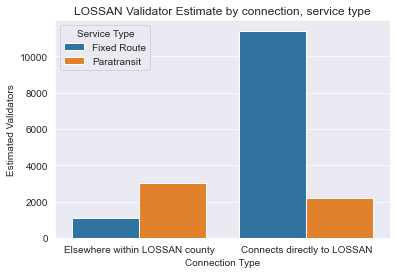

In [303]:
plt = sns.barplot(x='Connection Type', y='validator_count', hue='Service Type', data=grouped)
# plt.set_xlabel('Connects directly to LOSSAN')
plt.set_ylabel('Estimated Validators')
plt.set_title('LOSSAN Validator Estimate by connection, service type');

In [305]:
grouped

,validator_count,Service Type,Connection Type
0,1092.0,Fixed Route,Elsewhere within LOSSAN county
1,3040.0,Paratransit,Elsewhere within LOSSAN county
2,11417.0,Fixed Route,Connects directly to LOSSAN
3,2194.0,Paratransit,Connects directly to LOSSAN


In [309]:
grouped['validator_count'].sum() ## Estimate for all services, including paratransit

17743.0

In [310]:
grouped[grouped['Service Type'] == 'Fixed Route']['validator_count'].sum() ## Estimate not including paratransit

12509.0